<a href="https://colab.research.google.com/github/sadrireza/Neural-Networks/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Men-Women Detection

In [1]:
#using os to count no. of files in each folder
import os

#to organize dataset directories
import shutil
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## 1. Dataset Preparation

### 1.1 Download Dataset from Koggle

In [2]:
'''since we need to upload kaggle.json file to be able to use kaggle datasets,
we use this method to upload a file from our system.
 the _ is used for temporary variables in python
 and we use it not to show the content of file here for security reasons'''
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
#A linux code to transfer the file because colab base is linux
!mkdir ~/.kaggle #make the directory in linux
!cp kaggle.json ~/.kaggle #copy in linux
!chmod 600 ~/.kaggle/kaggle.json #for security reasons,restricting access to file to the owner

#in windows we have to save kaggle.jason in this path:
#C:\Users\username\.kaggle
#We have to download kaggle.json from our personal area in kaggle website
#in the API section

In [4]:
#downloading dataset from kaggle website (!kaggle datasets download -d username/dataset name)
!kaggle datasets download -d saadpd/menwomen-classification

Dataset URL: https://www.kaggle.com/datasets/saadpd/menwomen-classification
License(s): copyright-authors
100% 805M/806M [00:07<00:00, 108MB/s]
100% 806M/806M [00:07<00:00, 116MB/s]


In [5]:
#unzipping dataset(-qq for not showing extracted files)
!unzip -qq menwomen-classification.zip

### 1.2 Dataset Evaluation

In [6]:
#to correct numerous places at the same time, use Alt
num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print (f'Train: Men: {num_men_train} & Women: {num_women_train}')
print (f'Test: Men: {num_men_test} & Women: {num_women_test}')

Train: Men: 1000 & Women: 1912
Test: Men: 418 & Women: 915


###1.3 Prepare Data Directories

In [7]:
'''
Dataset is not suitable rightnow
Dataset should be such that each folder contains only images of one class only
we can do this either with coding or manually in our system
'''

new_base_dir = pathlib.Path('men_vs_women_small') #the base directory is made

'''make_subset gets two indexes to know from which image begins
 and to which one ends in each folder'''

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ('men', 'women'):
        dir = new_base_dir / subset_name / category
        if not os.path.exists(dir):
          os.makedirs(dir) #All above folders and subfolder are made

        '''
        above we want to make a directory. the address of directory
        is like what is equal to dir. so the main directory is called new_base_dir
        and the subfolder is a name which we give in later (subset_name)
        and then we have two categories men and women
        '''

        #getting all files from the source directory by listdir
        files = os.listdir(os.path.join(base_dir, category))

        #getting names of those images we want from start index to end index
        fnames = [files[i] for i in range(start_index, end_index)]

        #copying those images to the destination directory
        for fname in fnames:
          shutil.copyfile(src=os.path.join(base_dir, category, fname),
                      dst=os.path.join(dir,fname))

          '''
To turn image files into batches of preprocessed tensors in general,
Keras features the utility function:
image_dataset_from_directory()
1-list the subdirectories of directory
2-assume each one contains one class
3-index the image files in each subd.
4-create and return a tf.data.Dataset object
this object configured to read files,
shuffle them, decode them to tensors, resize them to
a shared size,pack them into batches
'''

In [8]:
#now we use make_subset
make_subset('traindata/traindata', 'validation', start_index=0, end_index=200)
make_subset('traindata/traindata', 'train', start_index=200, end_index=999)
make_subset('testdata/testdata', 'test', start_index=0, end_index=400)

###1.4 Load Dataset

In [9]:
print ('Train loader:') #to determine which report is shown
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',
    image_size = (180,180),
    batch_size=32,
    label_mode = 'binary' #because we have only two classes
)
print ('Validation loader:') #to determine which report is shown
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size = (180,180),
    batch_size=32,
    label_mode = 'binary' #because we have only two classes
)

print ('Test loader:') #to determine which report is shown
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size = (180,180),
    batch_size=32,
    label_mode = 'binary' #because we have only two classes
)

Train loader:
Found 1598 files belonging to 2 classes.
Validation loader:
Found 400 files belonging to 2 classes.
Test loader:
Found 800 files belonging to 2 classes.


data batch shape: (32, 180, 180, 3)
label batch shape: (32, 1)


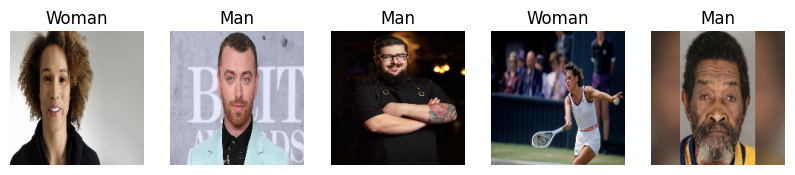

In [10]:
#showing 5 samples
for data_batch, label_batch in train_dataset:
  print('data batch shape:', data_batch.shape)
  print('label batch shape:', label_batch.shape)

  #Show five random examples of the loaded batch
  fig, axes = plt.subplots(1, 5, figsize = (10,3))
  for i, ax in enumerate(axes):
    ax.imshow(data_batch[i].numpy().astype('uint8'))
    ax.set_axis_off()
    ax.set_title('Man' if label_batch[i].numpy()==0 else 'Woman')
  break
plt.show()

## 2. Building  the Model

###2.0 Model Augmentation

In [28]:
#Keras has this feature that we can add a complete model as a leyer to another model
#we use data augmentation to increase the quantity of data without actually collecting new data
#so we define a simple sequential keras model

data_augmentation = keras.Sequential(
 [
     layers.RandomFlip('horizontal'), #apply horizontal flipping to random 50% of images that go through it
     layers.RandomRotation(0.1), #Rotate input image by random value in range(-10%,10%)
     layers.RandomZoom(0.2), #zoom or out input images by random value in range(-20%,20%)
 ]
)

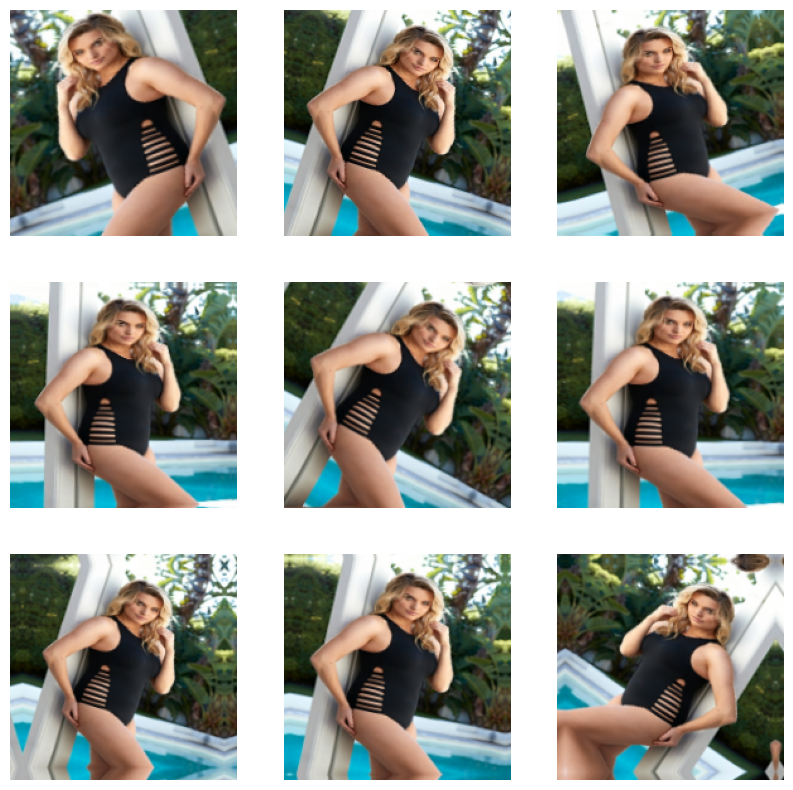

In [36]:
#Displaying some randomly augmented training images
plt.figure(figsize=(10,10)) #displaying augmented image
for images, _ in train_dataset.take(1): #takes 1 batch of train_dataset, _means that labels are not important for augmentation
  for i in range(9): #creating 9 augmented images
    augmented_images = data_augmentation(images) #applying data augmentation pipeline to batch of images
    ax = plt.subplot(3, 3, i +1) #creating a 3x3 subplot and putting each augmented image in one spot
    plt.imshow(augmented_images[0].numpy().astype('uint8')) #converting augmented tensor to numpy array (suitable for imshow) and then casting it to unit8 (to be able to show it)
    plt.axis('off')

###2.1 Building

In [37]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs) #as simple as that we add a complete model as a layer to another model
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers. MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers. MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

###2.2 Compilation

In [38]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

2.3 Fitting the Model



In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='covnet_from_scratch.keras',
        save_best_only=True,
        monitor='val_loss'
        )
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - accuracy: 0.4869 - loss: 0.6965 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.5239 - loss: 0.7057 - val_accuracy: 0.5775 - val_loss: 0.6826
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.5723 - loss: 0.6822 - val_accuracy: 0.5525 - val_loss: 0.6757
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.5977 - loss: 0.6739 - val_accuracy: 0.5600 - val_loss: 0.6928
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 288ms/step - accuracy: 0.5925 - loss: 0.6764 - val_accuracy: 0.5525 - val_loss: 0.6926
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 325ms/step - accuracy: 0.5973 - loss: 0.6725 - val_accuracy: 0.5725 - val_loss: 0.6708
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 268ms/step - accuracy: 0.6106 - loss: 0.6651 - val_accuracy: 0.5675 - val_loss: 0.6969
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - accuracy: 0.6058 - loss: 0.6723 - val_accu

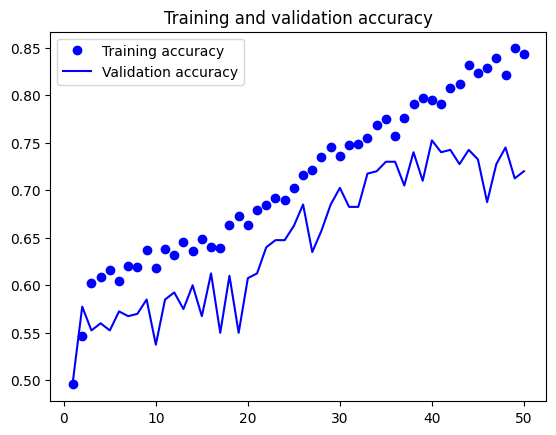

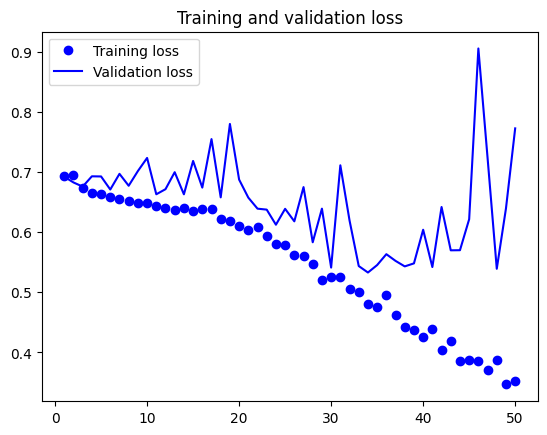

In [40]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#As we see here, the overfitting is less than the case which we did not have augmentation

###2.3 Evaluation

In [43]:
import os
print(os.listdir("."))

['.config', 'kaggle.json', 'testdata', 'menwomen-classification.zip', 'covnet_from_scratch.keras', 'traindata', 'men_vs_women_small', 'sample_data']


In [44]:
test_model = keras.models.load_model("/content/covnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.7338 - loss: 0.4830
Test accuracy: 0.755
